In [6]:
import pandas as pd
import numpy as np
import plotly.express as px
from mlquantify.utils import convert_columns_to_arrays

In [7]:
df = pd.read_csv("quantification_results.csv")
df = convert_columns_to_arrays(df)

# Remove outliers from 'rae' column using the IQR method

q1 = df['rae'].quantile(0.25)
q3 = df['rae'].quantile(0.75)
iqr = q3 - q1
df = df[(df['rae'] >= q1 - 8 * iqr) & (df['rae'] <= q3 + 8 * iqr)]

df = df[df["QUANTIFIER"] != "PWK"]

df

,ITERATION,QUANTIFIER,REAL_PREVS,PRED_PREVS,BATCH_SIZE,mae,rae,hotel,aspect
0,1,CC,"[0.0, 1.0]","[0.0, 1.0]",25,0.000000e+00,0.000000e+00,bourbon,Atendimento da equipe
2,1,EMQ,"[0.0, 1.0]","[1.62135303e-14, 1.0]",25,1.610496e-14,2.568766e-12,bourbon,Atendimento da equipe
3,1,FM,"[0.0, 1.0]","[0.0, 1.0]",25,0.000000e+00,0.000000e+00,bourbon,Atendimento da equipe
4,1,GPAC,"[0.0, 1.0]","[0.0, 1.0]",25,0.000000e+00,0.000000e+00,bourbon,Atendimento da equipe
6,1,ACC,"[0.0, 1.0]","[0.0, 1.0]",25,0.000000e+00,0.000000e+00,bourbon,Atendimento da equipe
...,...,...,...,...,...,...,...,...,...
152977,1,DyS,"[1.0, 0.0]","[0.98084301, 0.01915699]",49,1.882670e-02,1.101444e+00,viale_tower,Localização
152979,1,HDy,"[1.0, 0.0]","[1.0, 0.0]",49,0.000000e+00,0.000000e+00,viale_tower,Localização
152993,1,T50,"[1.0, 0.0]","[1.0, 0.0]",57,0.000000e+00,0.000000e+00,viale_tower,Localização
152995,1,DyS,"[1.0, 0.0]","[0.98996678, 0.01003322]",57,9.860232e-03,5.768665e-01,viale_tower,Localização


In [8]:
# Supondo que você já extraiu os dados da tabela para um DataFrame chamado df.
# O DataFrame deve conter as colunas: 'ITERATION', 'QUANTIFIER', 'REAL_PREVS', 'PRED_PREVS', 'BATCH_SIZE', 'mae', 'rae', 'hotel', 'aspect'

filtered_aspects = ['Atendimento da equipe', 'Quarto', 'Café da manhã', 'Localização', 'Áreas comuns']
filtered_hotels = ['bourbon', 'taroba', 'viale_cataratas', 'viale_tower']

df_filtered = df[df['aspect'].isin(filtered_aspects) & df['hotel'].isin(filtered_hotels)]
df_filtered['mae'] = pd.to_numeric(df_filtered['mae'], errors='coerce')

# Agrupar por hotel, aspecto e quantifier e calcular a média do mae
grouped = df_filtered.groupby(['hotel', 'aspect', 'QUANTIFIER'], as_index=False)['mae'].mean()

# Agora recria as tabelas usando o DataFrame agrupado e a lista atualizada de hotéis
filtered_hotels = grouped['hotel'].unique()
filtered_aspects = ['Atendimento da equipe', 'Quarto', 'Café da manhã', 'Localização', 'Áreas comuns']

mae_compare = []
for hotel in filtered_hotels:
    for aspect in filtered_aspects:
        sub = grouped[(grouped['hotel'] == hotel) & (grouped['aspect'] == aspect)]
        if sub.empty:
            continue
        mae_cc = sub[sub['QUANTIFIER'] == 'CC']['mae'].min() if not sub[sub['QUANTIFIER'] == 'CC'].empty else np.nan
        best_row = sub.loc[sub['mae'].idxmin()] if not sub.empty else None
        best_quant = best_row['QUANTIFIER'] if best_row is not None else None
        best_mae = best_row['mae'] if best_row is not None else None
        mae_compare.append([hotel, aspect, mae_cc, best_quant, best_mae])

mae_compare_table = pd.DataFrame(mae_compare, columns=['Hotel', 'Aspect', 'CC', 'Best_Quantifier', 'Best_MAE'])

# Preparar os dados para a tabela hierárquica

# Usar uma função para extrair as colunas desejadas para cada aspecto
rows = []
for hotel in mae_compare_table['Hotel'].unique():
    row = {'Hotel': hotel}
    for aspect in filtered_aspects:
        # Filtrar a linha do hotel e aspecto
        sub = mae_compare_table[(mae_compare_table['Hotel'] == hotel) & (mae_compare_table['Aspect'] == aspect)]
        if sub.empty:
            # Colocar NaN quando não existir esse aspecto para o hotel
            row[(aspect, 'CC')] = np.nan
            row[(aspect, 'BEST')] = ''
        else:
            row[(aspect, 'CC')] = np.round(sub['CC'].values[0], 3)
            # melhor quantificador

            best_mae = np.round(sub['Best_MAE'].values[0], 3)
            best_quantifier = sub['Best_Quantifier'].values[0]

            row[(aspect, 'BEST')] = f"{best_mae} ({best_quantifier})"
    rows.append(row)

# Criar DataFrame com MultiIndex na coluna
df_hier = pd.DataFrame(rows)

# Definir MultiIndex nas colunas (excluir 'Hotel' de MultiIndex)
cols = pd.MultiIndex.from_tuples([(col if isinstance(col, tuple) else ('', col)) for col in df_hier.columns])
df_hier.columns = cols

# Tornar a coluna 'Hotel' como índice para melhor visualização
df_hier = df_hier.set_index(('', 'Hotel'))

# Ajustar o nome do índice para ficar somente 'Hotel'
df_hier.index.name = 'Hotel'

df_hier

C:\Users\Luiz Fernando\AppData\Local\Temp\ipykernel_14124\1925664517.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['mae'] = pd.to_numeric(df_filtered['mae'], errors='coerce')


Atendimento da equipe              Quarto               \
                                   CC         BEST     CC         BEST   
Hotel                                                                    
bourbon                         0.022   0.02 (DyS)  0.075  0.034 (HDy)   
taroba                          0.033  0.022 (MAX)  0.054  0.022 (DyS)   
viale_cataratas                 0.014  0.013 (DyS)  0.049  0.032 (EMQ)   
viale_tower                     0.044  0.028 (HDy)  0.060  0.027 (HDy)   

                Café da manhã                   Localização               \
                           CC              BEST          CC         BEST   
Hotel                                                                      
bourbon                 0.097       0.041 (DyS)       0.176  0.053 (DyS)   
taroba                  0.063  0.028 (X_method)       0.063  0.031 (HDy)   
viale_cataratas         0.091       0.068 (MAX)         NaN                
viale_tower             0.058       0.038 (HDy)       0.135  0.072 (HDy)   

                Áreas comuns                    
                          CC              BEST  
Hotel                                           
bourbon                0.026  0.016 (X_method)  
taroba                 0.059       0.025 (DyS)  
viale_cataratas        0.064       0.038 (DyS)  
viale_tower            0.038        0.02 (DyS)

In [9]:
mae_std = []
for hotel in filtered_hotels:
    for aspect in filtered_aspects:
        sub = df_filtered[(df_filtered['hotel'] == hotel) & (df_filtered['aspect'] == aspect) & (df_filtered['QUANTIFIER'] == 'CC')]
        std_mae = sub['mae'].std() if not sub.empty else np.nan
        mae_std.append([hotel, aspect, std_mae])
mae_std_table = pd.DataFrame(mae_std, columns=['Hotel', 'Aspect', 'MAE_CC_STD'])
print('Tabela 2: Desvio padrão MAE CC')

mae_std_table


Tabela 2: Desvio padrão MAE CC


,Hotel,Aspect,MAE_CC_STD
0,bourbon,Atendimento da equipe,0.017254
1,bourbon,Quarto,0.056496
2,bourbon,Café da manhã,0.068150
3,bourbon,Localização,0.110691
4,bourbon,Áreas comuns,0.025347
5,taroba,Atendimento da equipe,0.026672
6,taroba,Quarto,0.040940
7,taroba,Café da manhã,0.046358
8,taroba,Localização,0.045433
9,taroba,Áreas comuns,0.043120


C:\Users\Luiz Fernando\AppData\Local\Temp\ipykernel_14124\3384138846.py:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["QUANTIFIER"].replace({"X_method": "X"}, inplace=True)
C:\Users\Luiz Fernando\AppData\Local\Temp\ipykernel_14124\3384138846.py:45: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select th

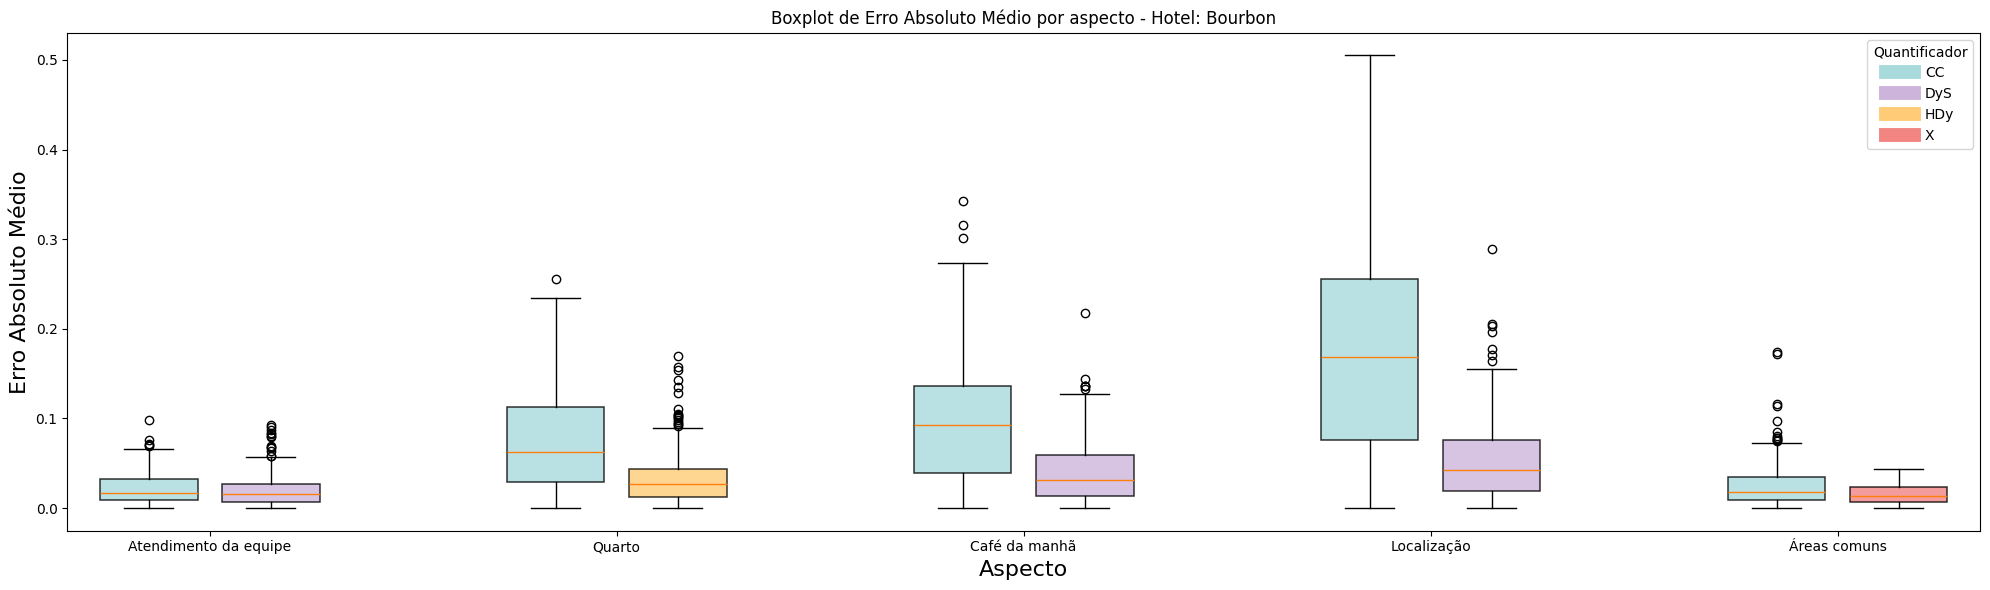

C:\Users\Luiz Fernando\AppData\Local\Temp\ipykernel_14124\3384138846.py:45: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  melhores = df_hotel.groupby('aspect').apply(


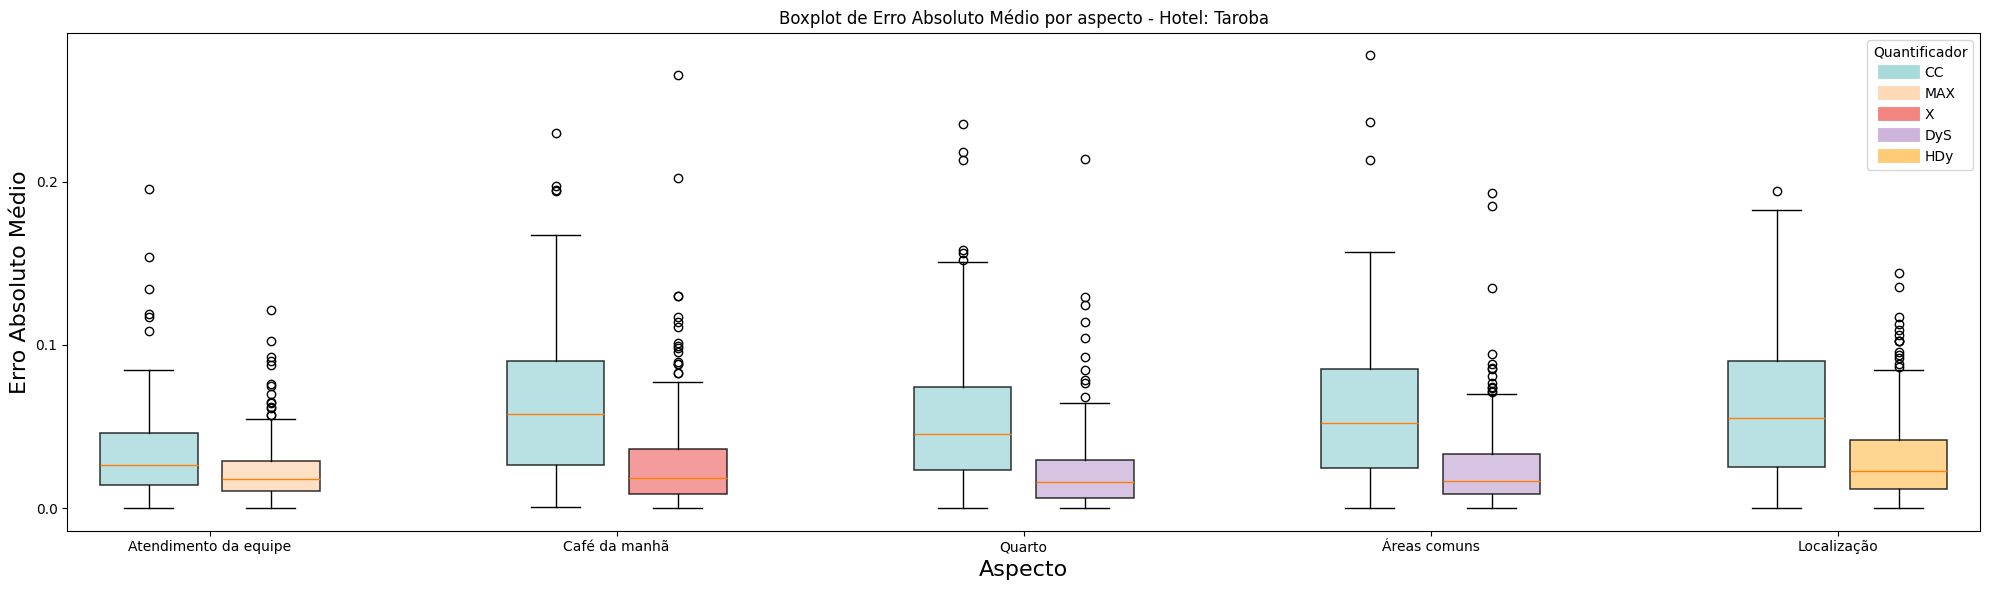

C:\Users\Luiz Fernando\AppData\Local\Temp\ipykernel_14124\3384138846.py:45: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  melhores = df_hotel.groupby('aspect').apply(


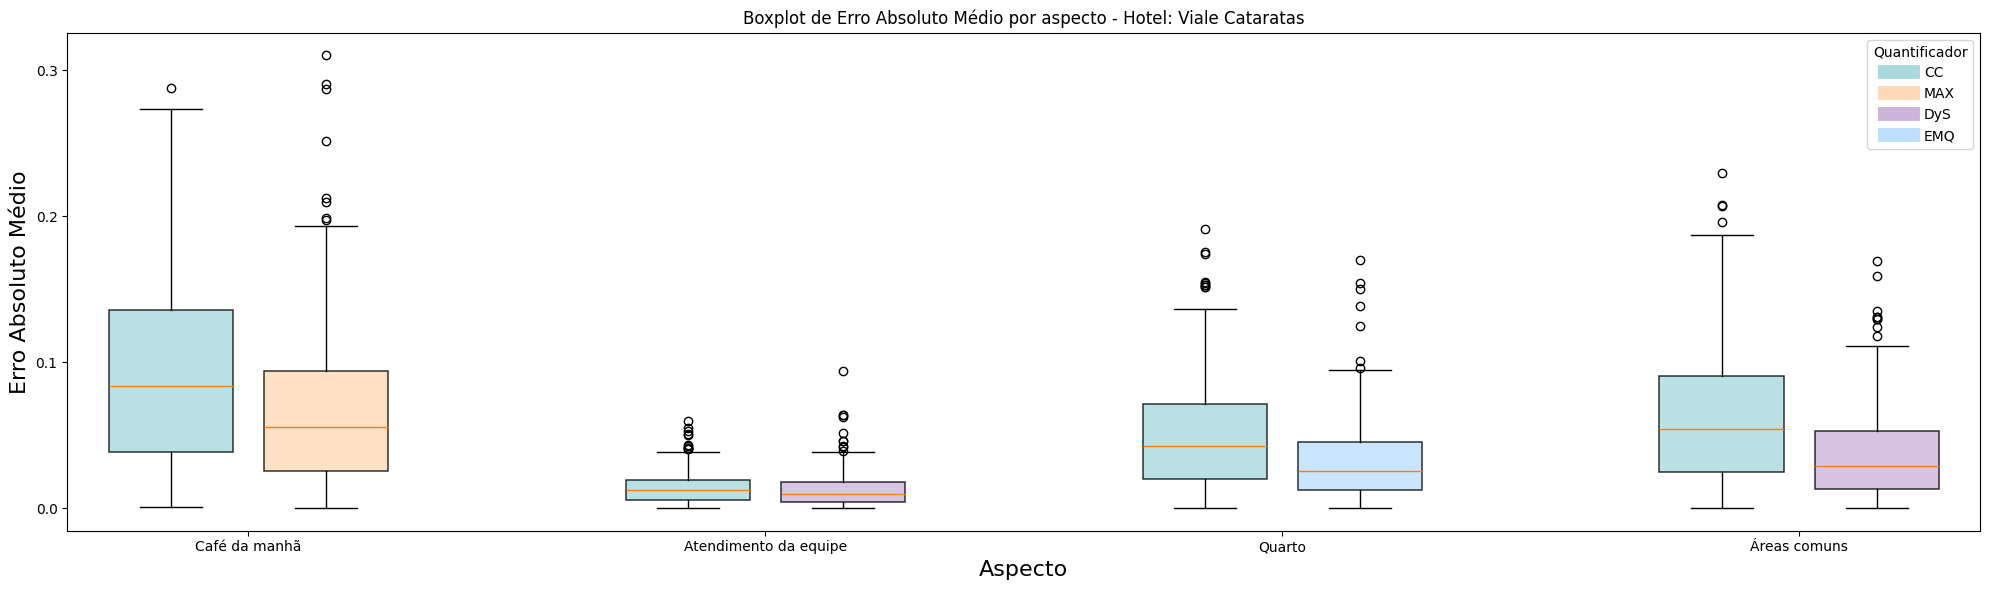

C:\Users\Luiz Fernando\AppData\Local\Temp\ipykernel_14124\3384138846.py:45: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  melhores = df_hotel.groupby('aspect').apply(


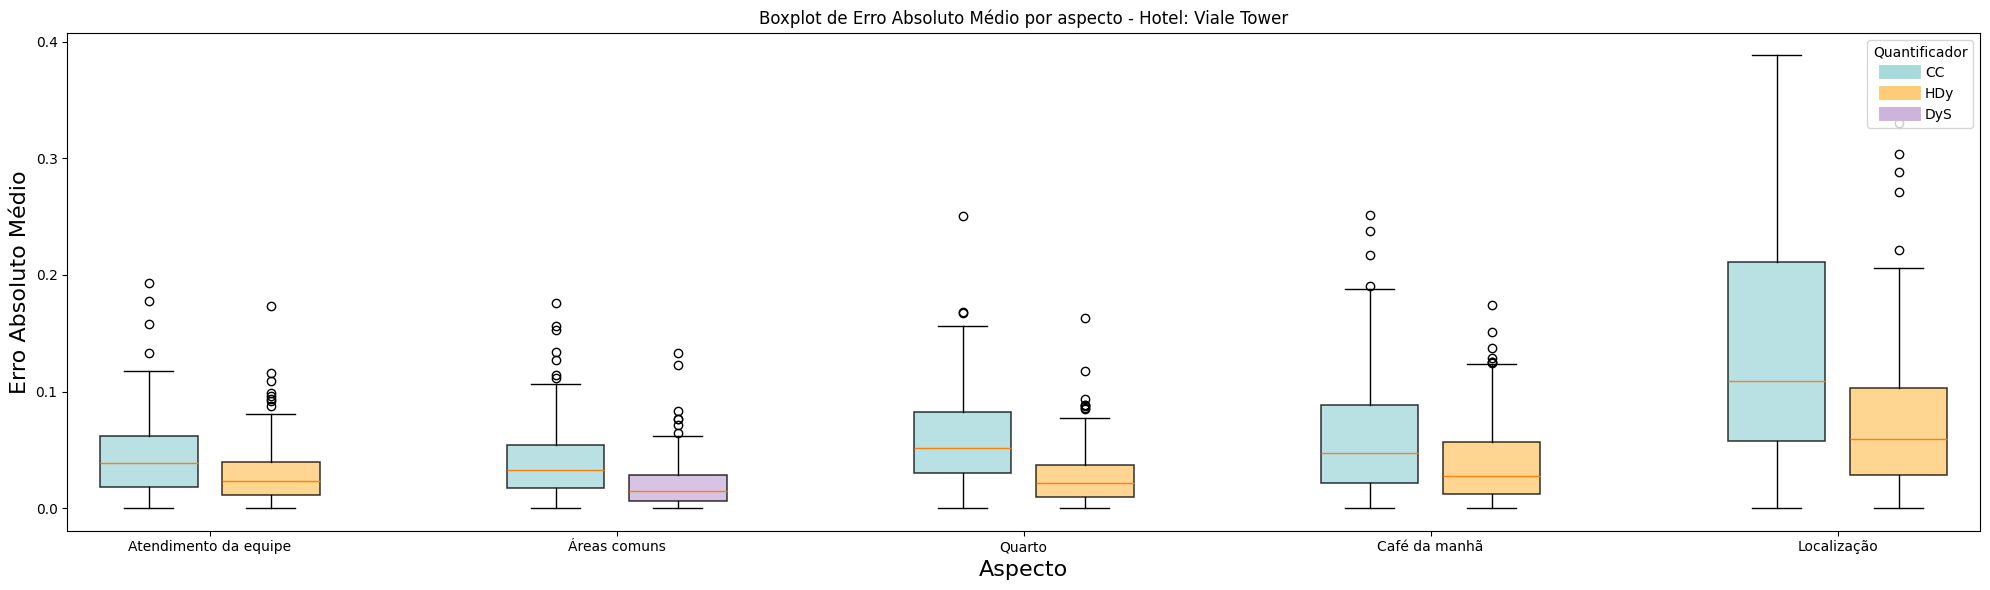

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# Garante fundo completamente branco
plt.style.use('default')
plt.rcParams.update({
    'figure.facecolor': 'white',
    'axes.facecolor':   'white',
    'savefig.facecolor':'white'
})

# Dicionário de cores pastel
pastel_colors = {
    "CC": "#a8dadc",
    "ACC": "#ffb4a2",
    "DyS": "#cdb4db",
    "DySsyn": "#ffc8dd",
    "EMQ": "#bde0fe",
    "FM": "#a2d2ff",
    "GPAC": "#f1faee",
    "HDy": "#ffcb77",
    "MAX": "#fed9b7",
    "MS": "#bde0fe",
    "MS2": "#c1ffd7",
    "PACC": "#fad4d4",
    "PCC": "#d0f4de",
    "PWK": "#dcedc2",
    "SMM": "#ccebc5",
    "SORD": "#ffb4a2",
    "T50": "#f6bd60",
    "X": "#f28482"
}


df = df[~df["hotel"].isin(["continental", "foz_plaza", "nadai"])].copy()
df = df[df["aspect"].isin(["Atendimento da equipe", "Quarto", "Café da manhã", "Localização", "Áreas comuns"])].copy()
hotels = df['hotel'].unique()
df["QUANTIFIER"].replace({"X_method": "X"}, inplace=True)

for hotel in hotels:
    df_hotel = df[df['hotel'] == hotel].copy()
    aspectos = df_hotel['aspect'].unique()

    melhores = df_hotel.groupby('aspect').apply(
        lambda d: d.groupby('QUANTIFIER')['mae'].mean().idxmin()
    ).to_dict()

    # Cria figura com DOIS subplots lado a lado
    fig, axes = plt.subplots(1, 1, figsize=(20, 6))
    errors = ["mae", "rae"]
    erro_descrito = ["Erro Absoluto Médio", "Erro Relativo Médio"]

    for idx in range(1):  # duas cópias (MAE e RAE)
        ax = axes
        box_data = []
        box_positions = []
        box_colors = []
        box_labels = []

        legenda_melhor = {}

        aspect_gap = 2.5
        inner_box_gap = 0.75

        for i, aspect in enumerate(aspectos):
            center = i * aspect_gap
            df_aspect = df_hotel[df_hotel['aspect'] == aspect]
            # CC
            y_cc = df_aspect[df_aspect['QUANTIFIER'] == "CC"][errors[idx]].dropna()
            box_data.append(y_cc)
            box_positions.append(center - inner_box_gap / 2)
            box_colors.append(pastel_colors["CC"])
            box_labels.append(f"{aspect}\nCC")

            # Melhor
            melhor_quant = melhores[aspect]
            y_melhor = df_aspect[df_aspect['QUANTIFIER'] == melhor_quant][errors[idx]].dropna()
            box_data.append(y_melhor)
            box_positions.append(center + inner_box_gap / 2)
            box_colors.append(pastel_colors[melhor_quant])
            box_labels.append(f"{aspect}\n{melhor_quant}")
            legenda_melhor[melhor_quant] = pastel_colors[melhor_quant]

        bplots = ax.boxplot(box_data, positions=box_positions, widths=0.6, patch_artist=True)
        for patch, color in zip(bplots['boxes'], box_colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.8)
            patch.set_linewidth(1.1)

        # Rotação dos labels do eixo x
        ax.set_xticks([i * aspect_gap for i in range(len(aspectos))])
        ax.set_xticklabels(aspectos)

        hotel_name = ' '.join(hotel.split("_")).title()

        ax.set_xlabel("Aspecto", fontsize=16)
        ax.set_ylabel(erro_descrito[idx], fontsize=16)
        ax.set_title(f"Boxplot de {erro_descrito[idx]} por aspecto - Hotel: {hotel_name}")

        # Ajuste do passo do eixo y
        if idx == 0:
            ax.yaxis.set_major_locator(MultipleLocator(0.1))
        else:
            ax.yaxis.set_major_locator(MultipleLocator(0.2))

        # Monta legenda sem duplicidade do CC
        legend_quantifiers = set()
        legend_handles = []
        # Adiciona CC uma única vez
        if "CC" in legenda_melhor or True:
            legend_handles.append(plt.Line2D([0], [0], color=pastel_colors["CC"], lw=10, label="CC"))
            legend_quantifiers.add("CC")
        for quant, cor in legenda_melhor.items():
            if quant != "CC" and quant not in legend_quantifiers:
                legend_handles.append(plt.Line2D([0], [0], color=cor, lw=10, label=quant))
                legend_quantifiers.add(quant)
        ax.legend(handles=legend_handles, title="Quantificador", loc='upper right')

    plt.tight_layout()
    fig.savefig(f'plots/{hotel_name}.pdf')
    plt.show()
